In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## 充電/放電結果

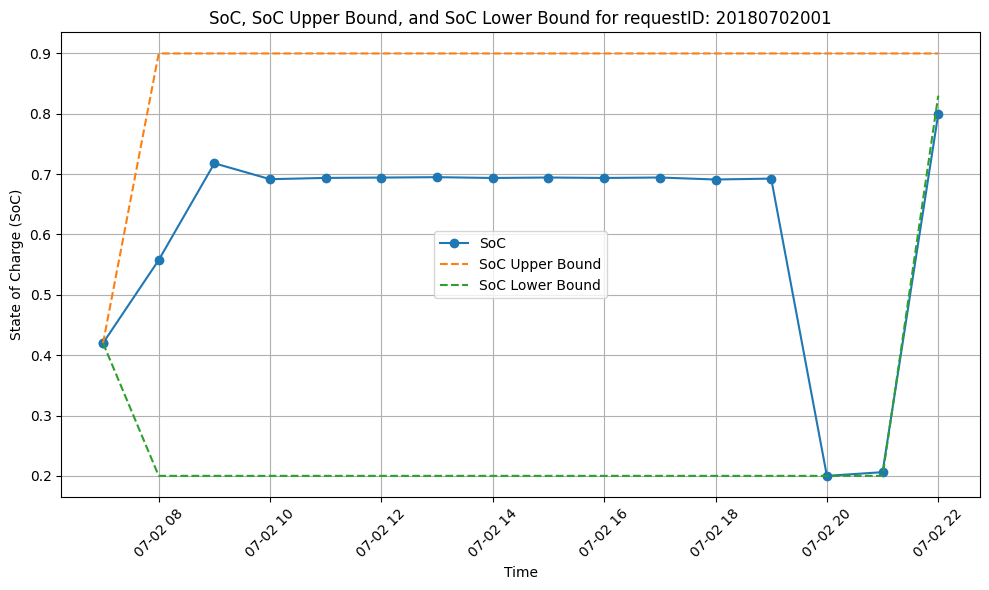

In [55]:
# Read the CSV file
file_path = './Result/GB-MARL_alpha0.5_beta0.5_num10/4/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage
plot_soc_for_requestID(20180702001)  # Replace with the desired requestID


## 原始負載與 EV 充放電的負載變化圖

In [3]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

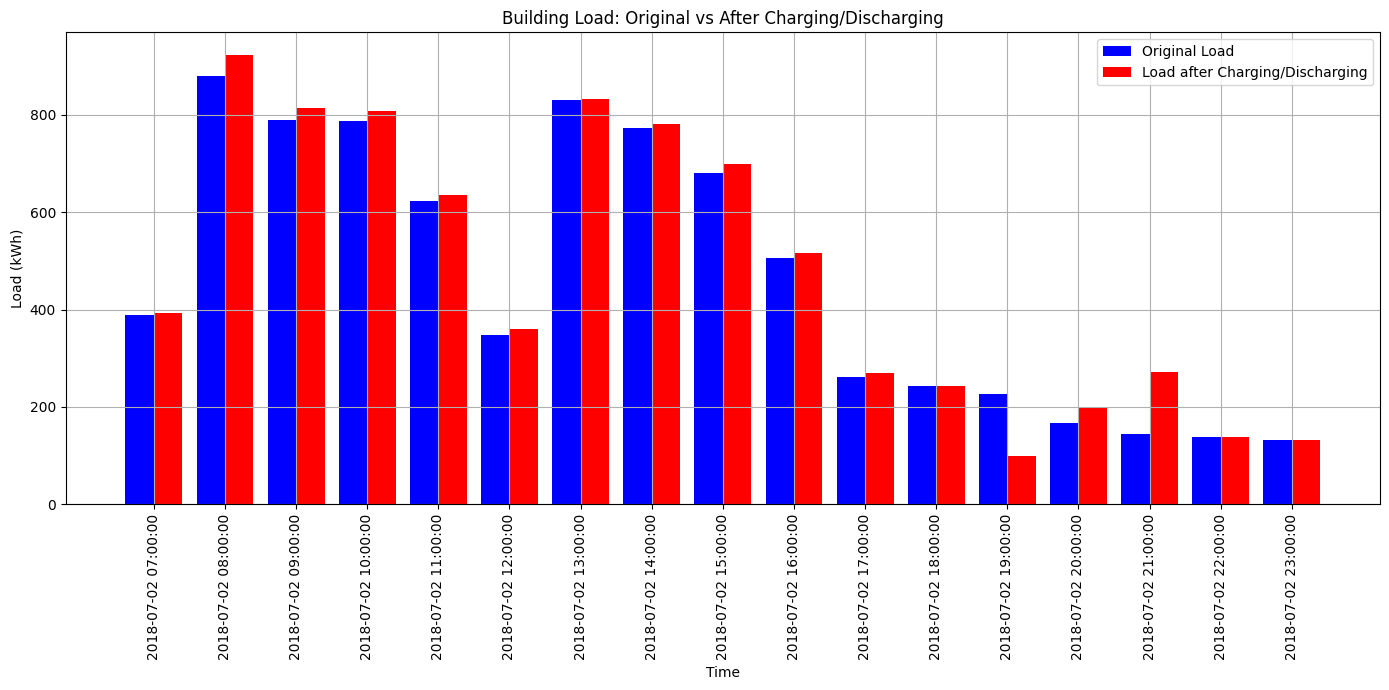

In [54]:
file_path = './Result/GB-MARL_alpha0.5_beta0.5_num10/4/building_loading_history.csv'  # Modify this to the path of your load history file
start_date = '2018-07-02'
end_date = '2018-07-03'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

plot_load_history(file_path, start_date, end_date)

## 計算峰谷比 (Peak-to-Valley Ratio)

In [77]:
start_date = '2018-07-01'
end_date = '2018-07-01'
start_hour = 7
end_hour = 23

start_time = datetime.strptime(f'{start_date} {start_hour}:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(f'{end_date} {end_hour}:00:00', '%Y-%m-%d %H:%M:%S')

In [78]:
df = pd.read_csv(file_path, parse_dates=['current_time'])
df['current_time'] = pd.to_datetime(df['current_time'])

def calculate_peak_to_valley_ratio(df, start_time, end_time):
    
    mask = (df['current_time'] >= start_time) & (df['current_time'] <= end_time)
    df_filtered = df[mask]

    max_load = df_filtered['total_load'].max()
    min_load = df_filtered['total_load'].min()

    # calculate peak to valley ratio
    peak_to_valley_ratio = max_load / min_load
    return peak_to_valley_ratio

In [79]:
ratio = calculate_peak_to_valley_ratio(df, start_time, end_time)
print(f'Peak-to-Valley Ratio from {start_time} to {end_time}: {ratio:.2f}')

Peak-to-Valley Ratio from 2018-07-01 08:00:00 to 2018-07-01 18:00:00: nan


## 計算建物使用電網用電的電力成本

Total cost for GB-MARL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $8222.06
Total overload penalty for GB-MARL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $1803.96
Total cost for MADDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $8654.68
Total overload penalty for MADDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $2269.21
Total cost for MARL-VDN from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $10623.07
Total overload penalty for MARL-VDN from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $4189.79
Total cost for MARL-IQL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $12093.47
Total overload penalty for MARL-IQL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $5639.38
Total cost for DDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $20337.05
Total overload penalty for DDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $13958.25
Total cost for RandomPower from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $13786.39
Total overload penalty for RandomPower from 

/tmp/ipykernel_4069919/2929080095.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)


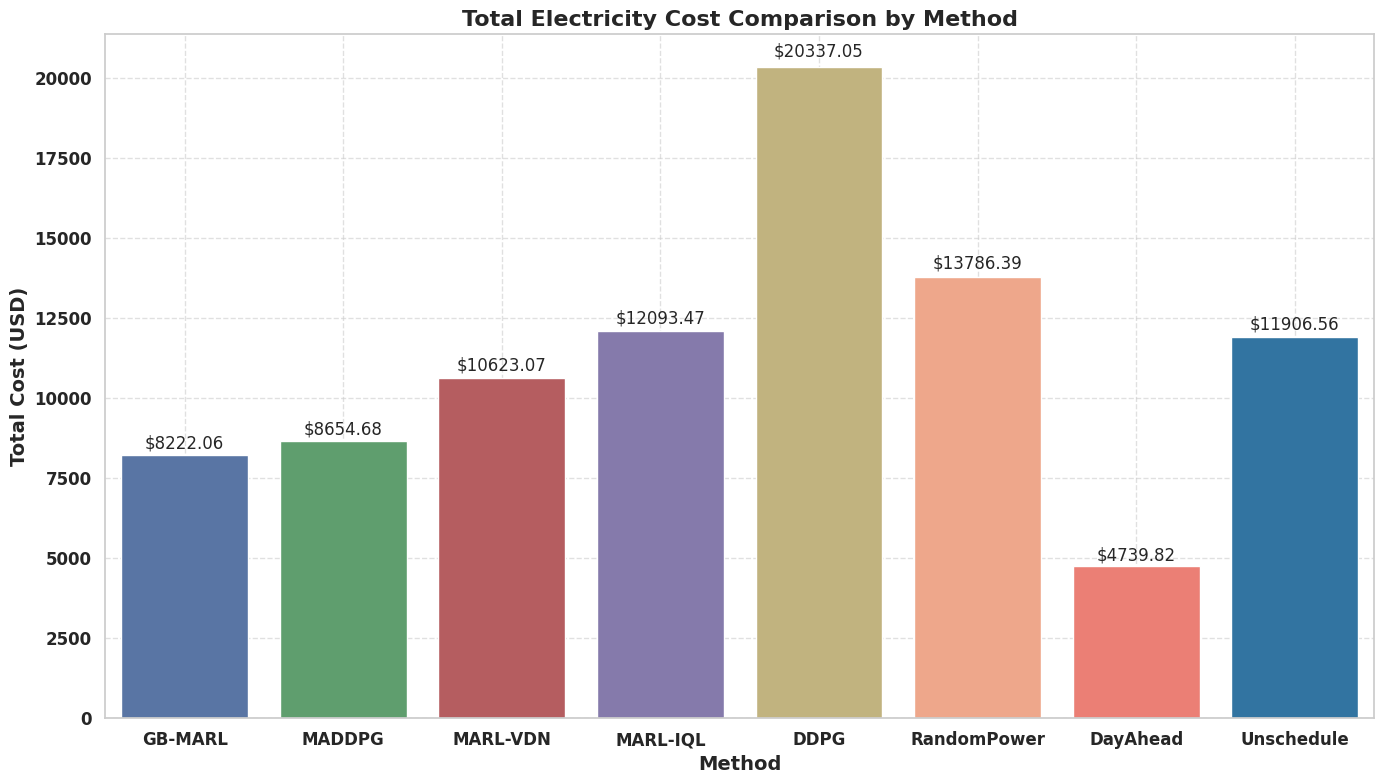

/tmp/ipykernel_4069919/2929080095.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)


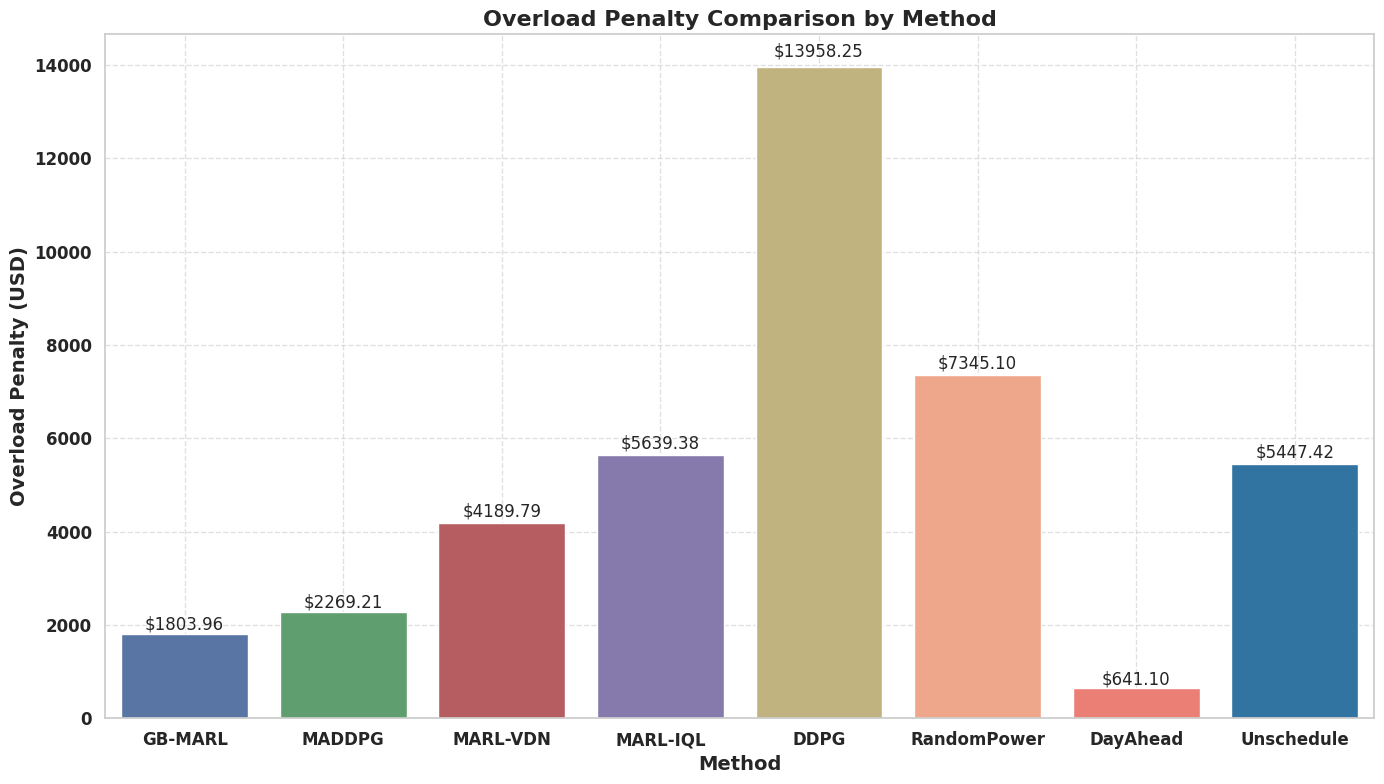

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from dotenv import load_dotenv
import seaborn as sns

# 加载 .env 文件中的环境变量
load_dotenv()

# 从环境变量中读取日期字符串并解析为 datetime 对象
start_datetime_str = '2018-07-01'
end_datetime_str = '2018-07-30'


# 解析为 datetime 对象
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')

# 选定的时间范围
start_time = start_datetime
end_time = end_datetime

# start_date = start_time.strftime('%Y-%m-%d')
# end_date = end_time.strftime('%Y-%m-%d')

def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

# 读取实时价格数据
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_time, end_time)

# 设置 contract_capacity 和 capacity_price
contract_capacity = 800
capacity_price = 15

# 计算成本和超约罚金的函数
def calculate_cost_and_penalty(df, real_time_price, start_time, end_time):
    # 过滤时间范围内的数据
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # 过滤每天 7 点到 23 点的数据
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # 将实时价格合并到 df_filtered 中
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # 计算每个时间点的成本
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # 计算总成本
    total_cost = df_filtered['cost'].sum()

    # 计算每个月的超约罚金
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # 超出契约容量 10% 以下的部分
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # 超出契约容量 10% 以上的部分

        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)
    return df_filtered, total_cost, total_overload_penalty

# 读取每个方法的 CSV 文件
GB_MARL_file = './Result/GB-MARL-TEST_07-01_10-01_10/1/building_loading_history.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/building_loading_history.csv'
VDN_file = './Result/VDN/3/building_loading_history.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/building_loading_history.csv'
DDPG_file = './Result/DDPG/2/building_loading_history.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/building_loading_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/building_loading_history.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/building_loading_history.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)

# 计算每个方法的总成本和超约罚金
total_costs = []
overload_penalties = []
for df, method_name in zip(data_frames, method_names):
    df_filtered, total_cost, total_overload_penalty = calculate_cost_and_penalty(df, real_time_price, start_time, end_time)
    total_cost += total_overload_penalty  # 包含超约罚金在总成本中
    total_costs.append(total_cost)
    overload_penalties.append(total_overload_penalty)
    print(f'Total cost for {method_name} from {start_time} to {end_time}: ${total_cost:.2f}')
    print(f'Total overload penalty for {method_name} from {start_time} to {end_time}: ${total_overload_penalty:.2f}')

# 设置图表样式
sns.set(style="whitegrid")

# 定义颜色列表，包含新的浅橙色
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4']

# 绘制总成本柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

# 添加标签和图例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Cost (USD)', fontsize=14, fontweight='bold')
ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 显示总成本在每个柱子上方
for bar, yval in zip(bars.patches, total_costs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# 绘制超约罚金柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# 添加标签和图例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 显示超约罚金在每个柱子上方
for bar, yval in zip(bars.patches, overload_penalties):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()


Basic tariff for GB-MARL: $12000.00
Current tariff for GB-MARL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $6418.09
Overload penalty for GB-MARL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $1803.96
Basic tariff for MADDPG: $12000.00
Current tariff for MADDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $6385.47
Overload penalty for MADDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $2269.21
Basic tariff for MARL-VDN: $12000.00
Current tariff for MARL-VDN from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $7031.83
Overload penalty for MARL-VDN from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $4189.79
Basic tariff for MARL-IQL: $12000.00
Current tariff for MARL-IQL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $7052.64
Overload penalty for MARL-IQL from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $5639.38
Basic tariff for DDPG: $12000.00
Current tariff for DDPG from 2018-07-01 00:00:00 to 2018-07-30 00:00:00: $6378.80
Overload penalty for DDPG from 2018-07-01 00:00:00

/tmp/ipykernel_4069919/4032641140.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=basic_tariffs, palette=colors, ax=ax)


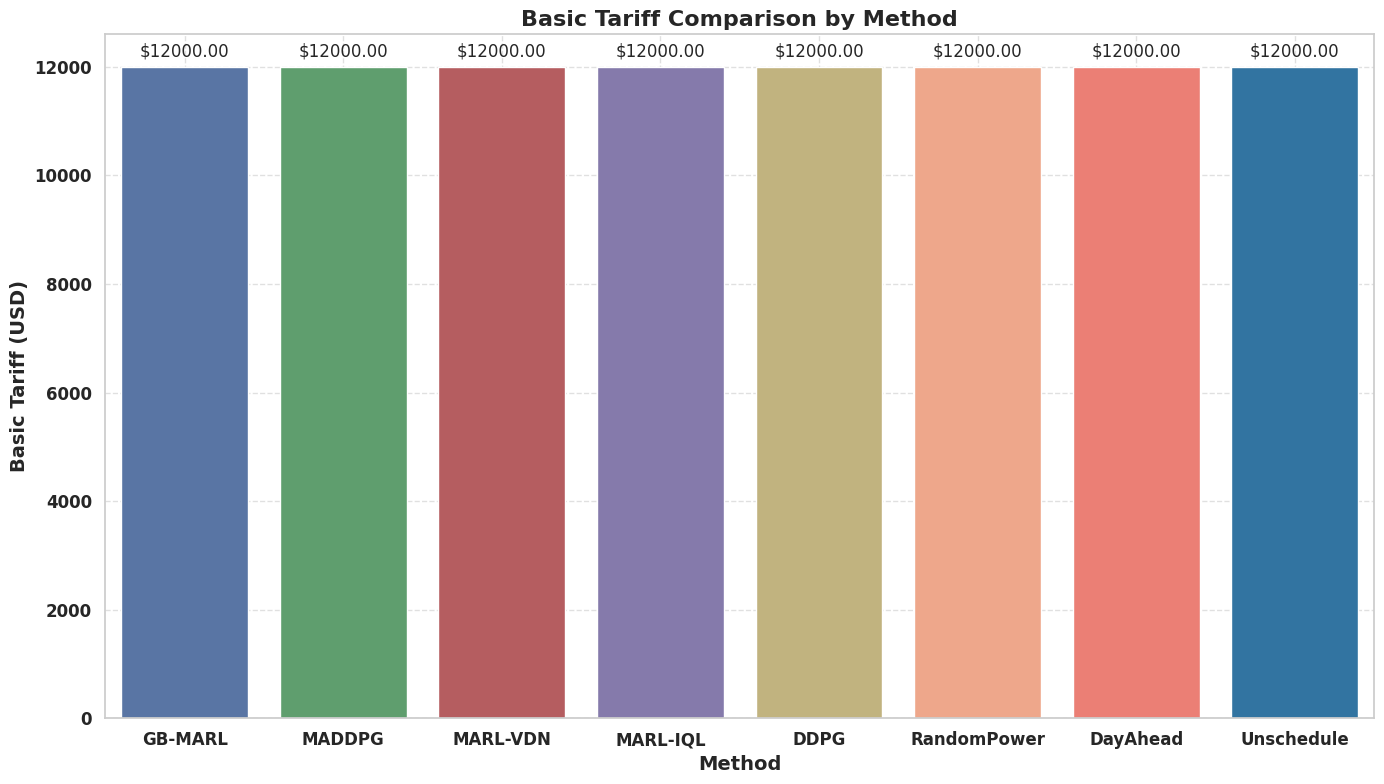

/tmp/ipykernel_4069919/4032641140.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)


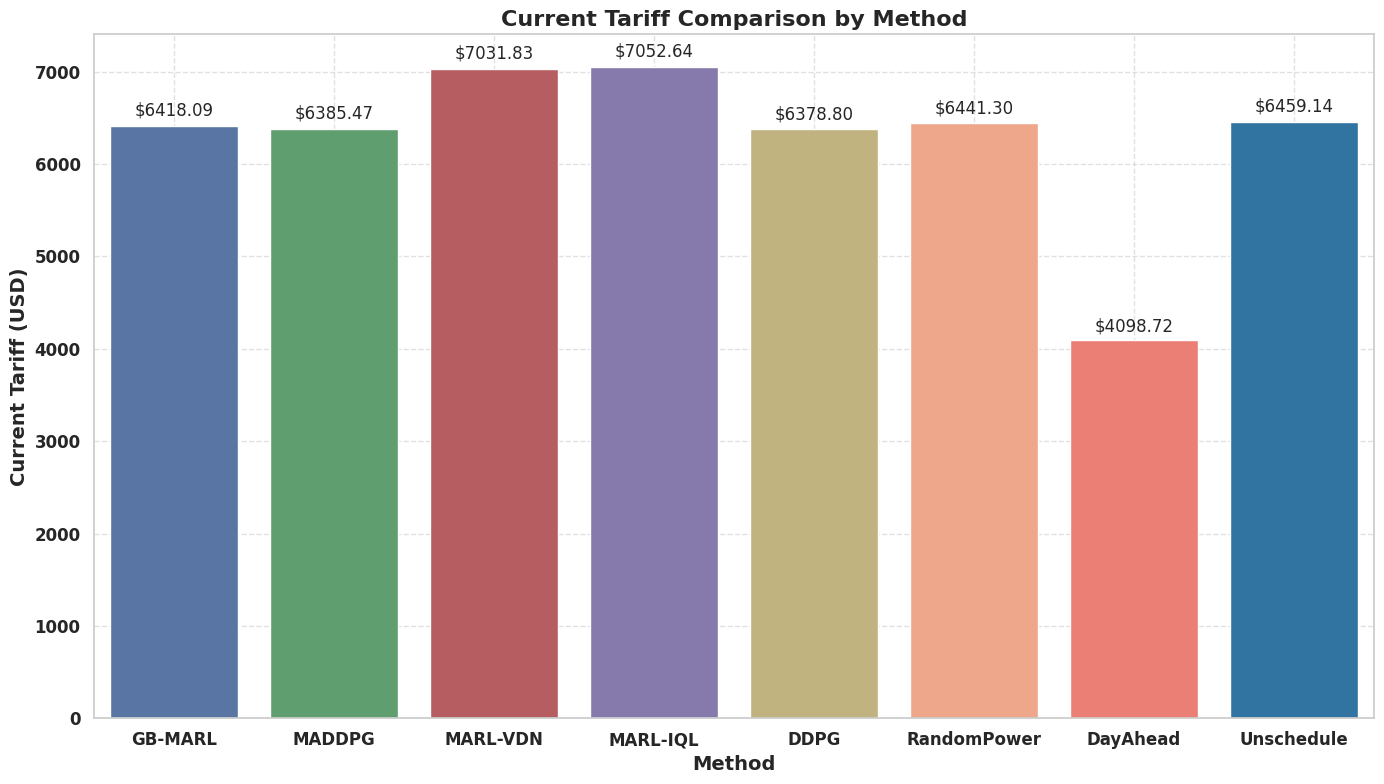

/tmp/ipykernel_4069919/4032641140.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)


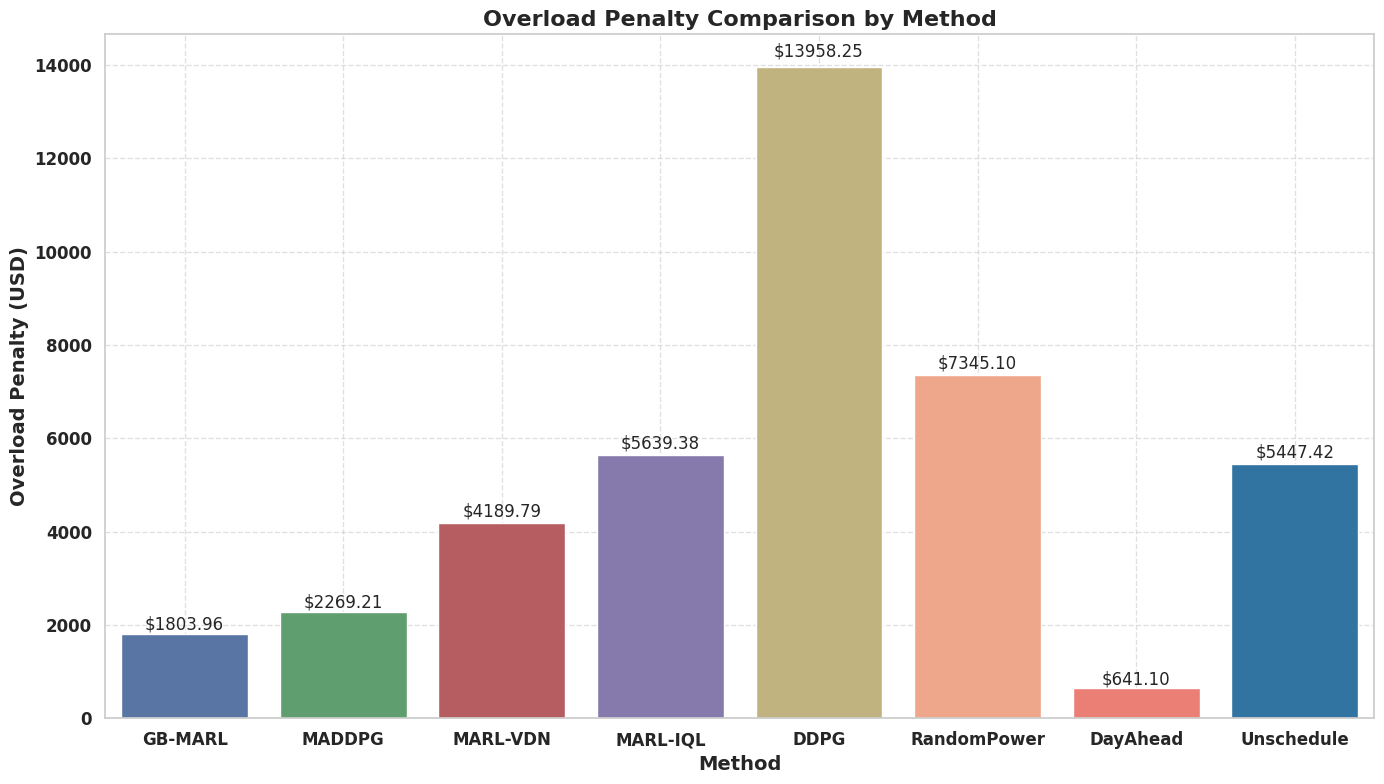

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from dotenv import load_dotenv
import seaborn as sns

# 加载 .env 文件中的环境变量
load_dotenv()

# 从环境变量中读取日期字符串并解析为 datetime 对象
start_datetime_str = '2018-07-01'
end_datetime_str = '2018-07-30'

# 解析为 datetime 对象
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')

# 选定的时间范围
start_time = start_datetime
end_time = end_datetime

def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

# 读取实时价格数据
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_time, end_time)

# 设置 contract_capacity 和 capacity_price
contract_capacity = 800
capacity_price = 15

# 计算基本费率的函数
def calculate_basic_tariff(contract_capacity, capacity_price):
    return contract_capacity * capacity_price

# 计算成本和超约罚金的函数
def calculate_cost_and_penalty(df, real_time_price, start_time, end_time, contract_capacity, capacity_price):
    # 过滤时间范围内的数据
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # 将实时价格合并到 df_filtered 中
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # 计算每个时间点的成本
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # 计算当前费率
    current_tariff = df_filtered['cost'].sum()

    # 计算每个月的超约罚金
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # 超出契约容量 10% 以下的部分
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # 超出契约容量 10% 以上的部分

        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)
    return df_filtered, current_tariff, total_overload_penalty

# 读取每个方法的 CSV 文件
GB_MARL_file = './Result/GB-MARL-TEST_07-01_10-01_10/1/building_loading_history.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/building_loading_history.csv'
VDN_file = './Result/VDN/3/building_loading_history.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/building_loading_history.csv'
DDPG_file = './Result/DDPG/2/building_loading_history.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/building_loading_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/building_loading_history.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/building_loading_history.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)

# 计算每个方法的总成本和超约罚金
basic_tariffs = []
current_tariffs = []
overload_penalties = []
for df, method_name in zip(data_frames, method_names):
    basic_tariff = calculate_basic_tariff(contract_capacity, capacity_price)
    df_filtered, current_tariff, total_overload_penalty = calculate_cost_and_penalty(df, real_time_price, start_time, end_time, contract_capacity, capacity_price)
    current_tariffs.append(current_tariff)
    overload_penalties.append(total_overload_penalty)
    basic_tariffs.append(basic_tariff)
    print(f'Basic tariff for {method_name}: ${basic_tariff:.2f}')
    print(f'Current tariff for {method_name} from {start_time} to {end_time}: ${current_tariff:.2f}')
    print(f'Overload penalty for {method_name} from {start_time} to {end_time}: ${total_overload_penalty:.2f}')

# 设置图表样式
sns.set(style="whitegrid")

# 定义颜色列表，包含新的浅橙色
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4']

# 绘制基本费率柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=basic_tariffs, palette=colors, ax=ax)

# 添加标签和图例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Basic Tariff (USD)', fontsize=14, fontweight='bold')
ax.set_title('Basic Tariff Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 显示基本费率在每个柱子上方
for bar, yval in zip(bars.patches, basic_tariffs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# 绘制当前费率柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

# 添加标签和图例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Current Tariff (USD)', fontsize=14, fontweight='bold')
ax.set_title('Current Tariff Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 显示当前费率在每个柱子上方
for bar, yval in zip(bars.patches, current_tariffs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# 绘制超约罚金柱状图
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# 添加标签和图例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 显示超约罚金在每个柱子上方
for bar, yval in zip(bars.patches, overload_penalties):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()



## Peak to valley ratio

2018-07-01 00:00:00 2018-07-07 00:00:00
Peak-to-Valley Ratio for GB-MARL from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 8.34
Peak-to-Valley Ratio for MADDPG from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 25.02
Peak-to-Valley Ratio for MARL-VDN from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 15.41
Peak-to-Valley Ratio for MARL-IQL from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 11.15
Peak-to-Valley Ratio for DDPG from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 33.70
Peak-to-Valley Ratio for RandomPower from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 44.53
Peak-to-Valley Ratio for DayAhead from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 8.14
Peak-to-Valley Ratio for Unschedule from 2018-07-01 to 2018-07-07 (07:00 to 23:00): 7.65


/tmp/ipykernel_4069919/3401997228.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=peak_to_valley_ratios, palette=colors, ax=ax)


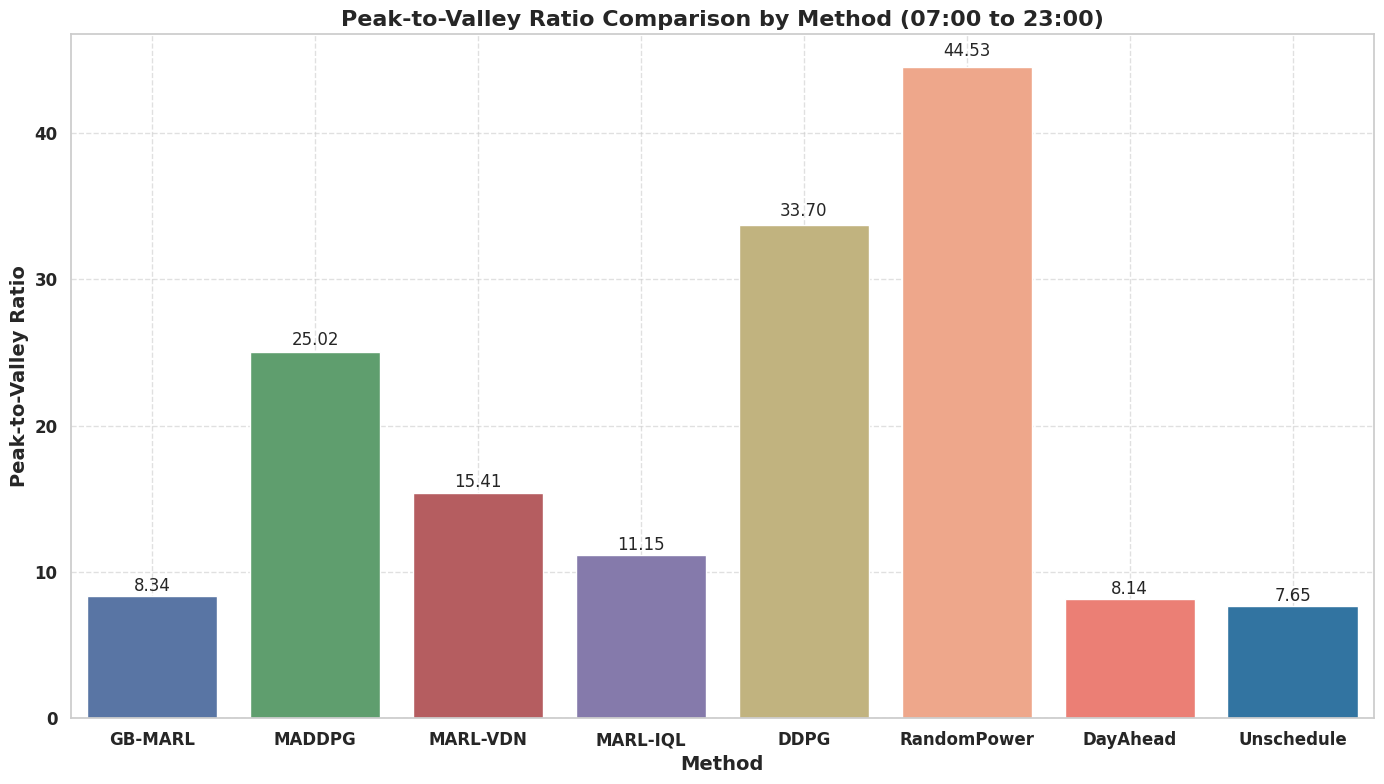

In [99]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import seaborn as sns

# 讀取每個方法的 CSV 文件
GB_MARL_file = './Result/GB-MARL-TEST_07-01_10-01_10/1/building_loading_history.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/building_loading_history.csv'
VDN_file = './Result/VDN/3/building_loading_history.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/building_loading_history.csv'
DDPG_file = './Result/DDPG/2/building_loading_history.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/building_loading_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/building_loading_history.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/building_loading_history.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)

# 从环境变量中读取日期字符串并解析为 datetime 对象
start_datetime_str = '2018-07-01'
end_datetime_str = '2018-07-07'

# 解析为 datetime 对象
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')

print(start_datetime, end_datetime)

# 定義每天的時間範圍
start_time = time(7, 0, 0)
end_time = time(23, 0, 0)

# 計算每個方法的峰谷比
peak_to_valley_ratios = []
for df, method_name in zip(data_frames, method_names):
    # 過濾選定日期範圍內的數據
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered_date = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)].copy()

    # 過濾每天 7 點到 23 點的數據
    df_filtered_time = df_filtered_date[(df_filtered_date['current_time'].dt.time >= start_time) & (df_filtered_date['current_time'].dt.time <= end_time)].copy()

    # 計算峰值和谷值
    peak_load = df_filtered_time['total_load'].max()
    valley_load = df_filtered_time['total_load'].min()
    peak_to_valley_ratio = peak_load / valley_load
    peak_to_valley_ratios.append(peak_to_valley_ratio)
    print(f'Peak-to-Valley Ratio for {method_name} from {start_datetime_str} to {end_datetime_str} (07:00 to 23:00): {peak_to_valley_ratio:.2f}')

# 設置圖表樣式
sns.set(style="whitegrid")

# 定義顏色列表，包含新的顏色
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4']

# 繪製長條圖
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=peak_to_valley_ratios, palette=colors, ax=ax)

# 添加標籤和圖例
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14, fontweight='bold')
ax.set_title('Peak-to-Valley Ratio Comparison by Method (07:00 to 23:00)', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 顯示峰谷比在每個柱子上方
for bar, yval in zip(bars.patches, peak_to_valley_ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()


2018-07-01 00:00:00 2018-07-30 00:00:00


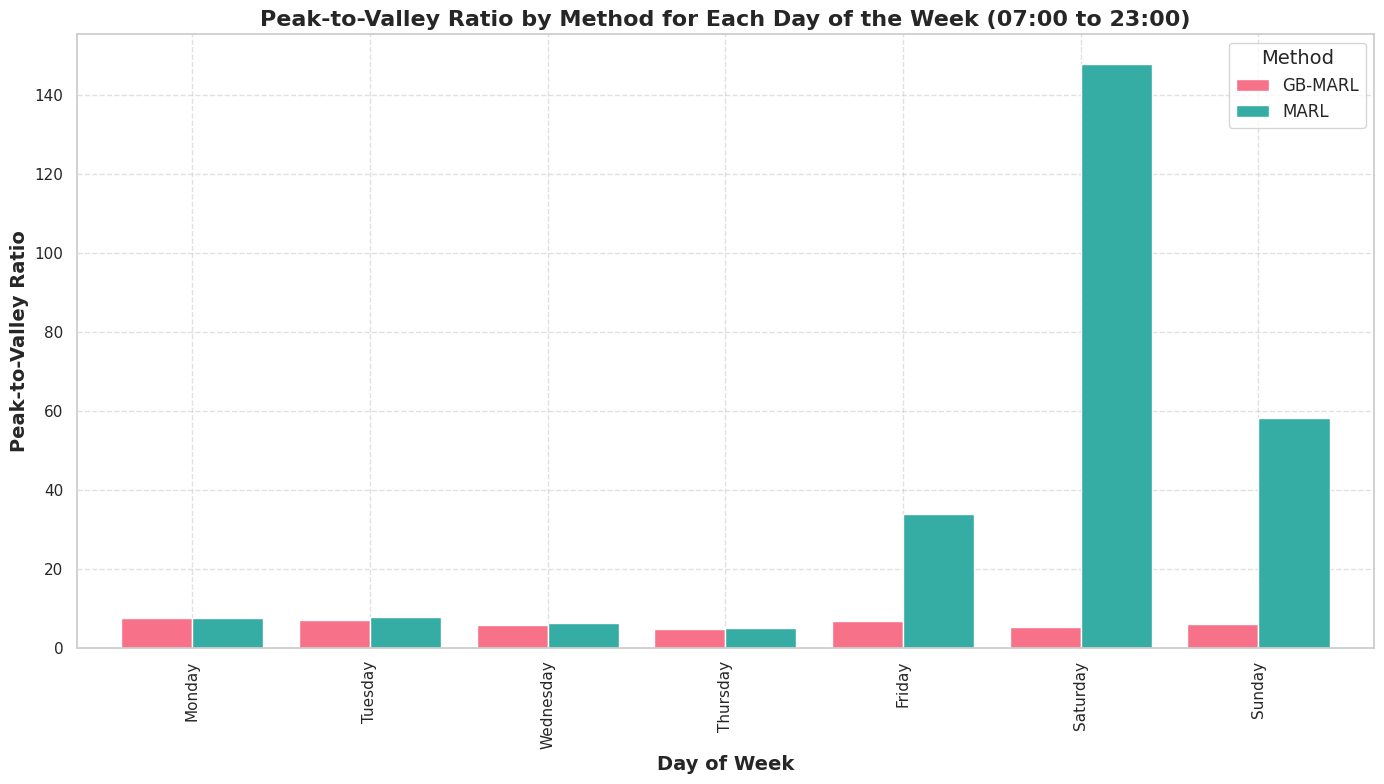

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import seaborn as sns
import os
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv()

# 从环境变量中读取日期字符串并解析为 datetime 对象
start_datetime_str = os.getenv('START_DATETIME', '2018-07-01').strip()
end_datetime_str = os.getenv('END_DATETIME', '2018-10-01').strip()
start_datetime_str = '2018-07-01'
end_datetime_str = '2018-07-30'
# 确保日期字符串是正确的格式
try:
    start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
    end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')
except ValueError as e:
    print(f"日期格式错误: {e}")
    exit(1)
print(start_datetime, end_datetime)
# 定义时间范围
start_time = datetime.strptime('07:00:00', '%H:%M:%S').time()
end_time = datetime.strptime('23:00:00', '%H:%M:%S').time()


# 读取每个方法的 CSV 文件
methods_files = {
    'GB-MARL': './Result/GB-MARL-TEST_07-01_10-01_10/1/building_loading_history.csv',
    'MARL': './Result/MARL_alpha0.5_beta0.5_num10/2/building_loading_history.csv',
    # 'VDN': './Result/VDN/2/building_loading_history.csv',
    # 'IQL': './Result/IQL/3/building_loading_history.csv',
    # 'RandomPower': './Result/RandomPower_07-01_10-01_10/1/building_loading_history.csv',
    # 'DayAheadSchedule': './Result/DayAheadSchedule/26/building_loading_history.csv',
    # 'Unschedule': './Result/Unschedule_07-01_10-01_10/2/building_loading_history.csv'
}

# 计算每个方法的每天平均负载和峰谷比
def calculate_daily_load_and_pvr(df):
    df['current_time'] = pd.to_datetime(df['current_time'])
    df['date'] = df['current_time'].dt.date
    df['day_of_week'] = df['current_time'].dt.day_name()

    # 过滤时间范围内的数据
    df = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)]
    
    avg_load = {day: [] for day in df['day_of_week'].unique()}
    pvr = {day: [] for day in df['day_of_week'].unique()}
    
    for day in df['day_of_week'].unique():
        df_day = df[df['day_of_week'] == day]
        df_day_time_filtered = df_day[(df_day['current_time'].dt.time >= start_time) & (df_day['current_time'].dt.time <= end_time)]
        
        if not df_day_time_filtered.empty:
            avg_load[day].append(df_day_time_filtered['total_load'].mean())
            peak_load = df_day_time_filtered['total_load'].max()
            valley_load = df_day_time_filtered['total_load'].min()
            pvr[day].append(peak_load / valley_load if valley_load > 0 else None)
    
    avg_load = {day: sum(values)/len(values) for day, values in avg_load.items() if values}
    pvr = {day: sum(values)/len(values) for day, values in pvr.items() if values}
    
    return avg_load, pvr

# 计算所有方法的每天平均负载和峰谷比
all_avg_load = {}
all_pvr = {}
for method_name, file_path in methods_files.items():
    df = pd.read_csv(file_path)
    avg_load, pvr = calculate_daily_load_and_pvr(df)
    all_avg_load[method_name] = avg_load
    all_pvr[method_name] = pvr

# 创建 DataFrame 以便绘图
pvr_df = pd.DataFrame(all_pvr)

# 将星期几按顺序排序
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pvr_df = pvr_df.reindex(day_order)

# 设置图表样式
sns.set(style="whitegrid")

# 定义颜色列表
colors = sns.color_palette("husl", len(methods_files))

# 绘制图表
fig, ax = plt.subplots(figsize=(14, 8))

# 绘制峰谷比的条形图
pvr_df.plot(kind='bar', ax=ax, color=colors, width=0.8)
ax.set_xlabel('Day of Week', fontsize=14, fontweight='bold')
ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14, fontweight='bold')
ax.set_title('Peak-to-Valley Ratio by Method for Each Day of the Week (07:00 to 23:00)', fontsize=16, fontweight='bold')
ax.legend(title='Method', fontsize=12, title_fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()


## Satisfication

/tmp/ipykernel_4069919/199358593.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4'])


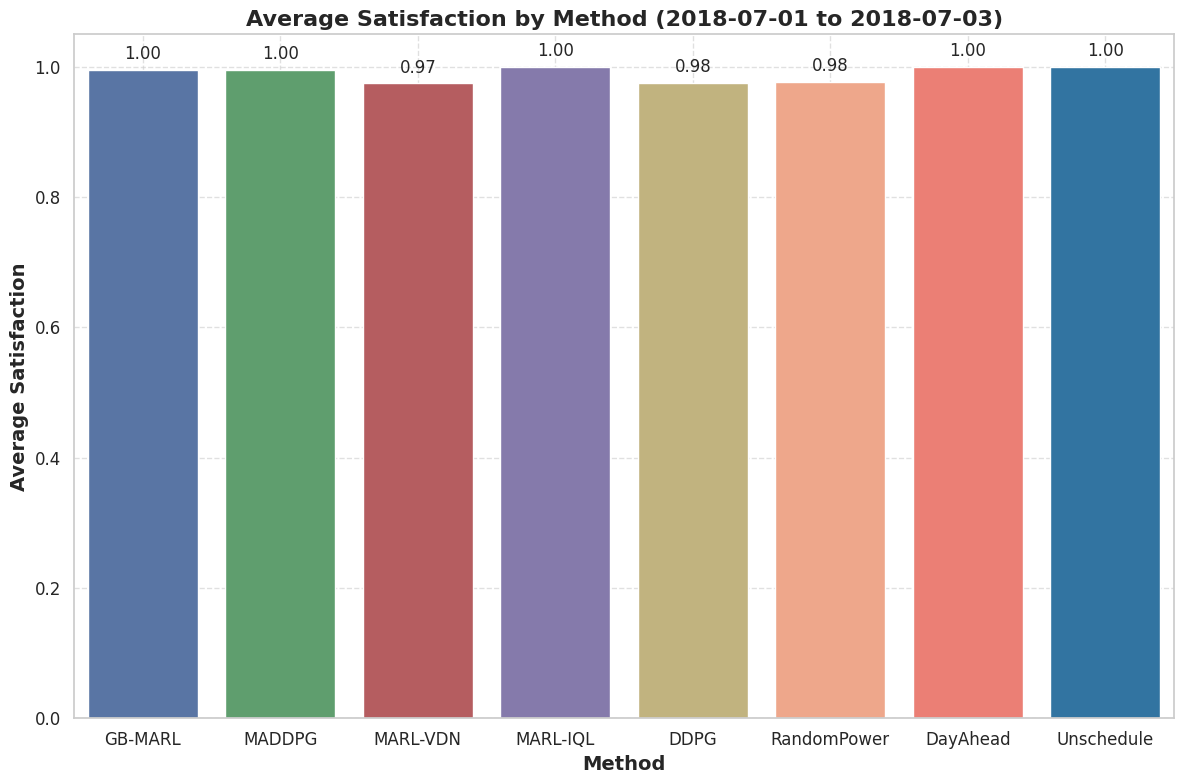

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# 定義計算滿意程度的函數
def calculate_satisfaction(df):
    df['satisfaction'] = df.apply(lambda x: 1 if x['final_soc'] >= x['departure_soc'] else x['final_soc'] / x['departure_soc'], axis=1)
    df['departure_time'] = pd.to_datetime(df['departure_time'])
    return df

# 讀取每個方法的 CSV 文件
GB_MARL_file = './Result/GB-MARL-TEST_07-01_10-01_10/1/charging_records.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/charging_records.csv'
VDN_file = './Result/VDN/3/charging_records.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/charging_records.csv'
DDPG_file = './Result/DDPG/2/charging_records.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/charging_records.csv'
DayAhead_file = './Result/DayAheadSchedule/26/charging_records.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/charging_records.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    df = calculate_satisfaction(df)
    data_frames.append(df)

# 選定的日期範圍
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 3)

# 計算每個方法的平均滿意程度
avg_satisfaction = []

for df in data_frames:
    df_filtered = df[(df['departure_time'] >= start_date) & (df['departure_time'] <= end_date)]
    avg_satisfaction.append(df_filtered['satisfaction'].mean())

# 設置圖表樣式
sns.set(style="whitegrid")

# 繪製每個方法的平均滿意程度
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4'])

# 添加標籤和圖例
plt.xlabel('Method', fontsize=14, fontweight='bold')
plt.ylabel('Average Satisfaction', fontsize=14, fontweight='bold')
plt.title(f'Average Satisfaction by Method ({start_date.date()} to {end_date.date()})', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# 顯示平均滿意度在每個柱子上方
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


/tmp/ipykernel_4069919/1618134164.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4'])


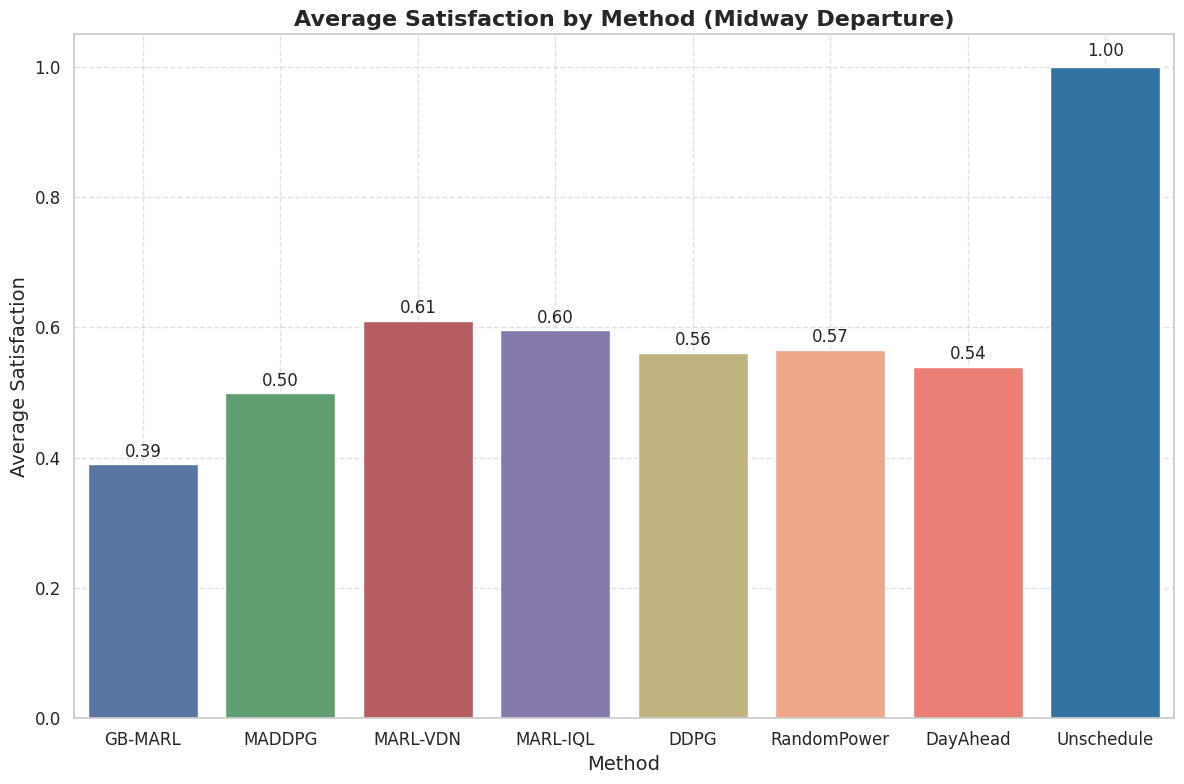

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 定義計算中途離開滿意程度的函數
def calculate_midway_satisfaction(df, start_date, end_date):
    # 先計算每個記錄的中間時間
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    
    # 過濾選定日期範圍內的記錄
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]

    # 對每個記錄計算在中間時間的滿意程度
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        if not mid_time_index.any():
            # 如果没有精确匹配的时间戳，则选择最接近的时间戳
            closest_index = (df['requestID'] == requestID) & (df['current_time'] >= start_date) & (df['current_time'] < end_date)
            closest_row = df[closest_index].iloc[(df[closest_index]['current_time'] - mid_time).abs().argsort()[:1]]
            midway_soc = closest_row['soc'].values[0]
        else:
            midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    return pd.Series(satisfaction)

# 讀取每個方法的 soc_history 文件
GB_MARL_file = './Result/GB-MARL_alpha0.5_beta0.5_num10/6/soc_history.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/soc_history.csv'
VDN_file = './Result/VDN/3/soc_history.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/soc_history.csv'
DDPG_file = './Result/DDPG/2/soc_history.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/soc_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/soc_history.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/soc_history.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

# 選定的日期範圍
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 30)

for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_date, end_date)
    data_frames.append(satisfaction)

# 計算每個方法的平均滿意程度
avg_satisfaction = [s.mean() for s in data_frames]

sns.set(style="whitegrid")
# 繪製每個方法的平均滿意程度
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4'])

# 添加標籤和圖例
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# 顯示平均滿意度在每個柱子上方
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()

In [145]:
import pandas as pd
from datetime import datetime

# 定义计算中途离开满意程度的函数
def calculate_midway_satisfaction(df, start_date, end_date):
    # 先计算每个记录的中间时间
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    
    # 过滤选定日期范围内的记录
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]

    # 对每个记录计算在中间时间的满意程度
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        if not mid_time_index.any():
            # 如果没有精确匹配的时间戳，则选择最接近的时间戳
            closest_index = (df['requestID'] == requestID) & (df['current_time'] >= start_date) & (df['current_time'] < end_date)
            closest_row = df[closest_index].iloc[(df[closest_index]['current_time'] - mid_time).abs().argsort()[:1]]
            midway_soc = closest_row['soc'].values[0]
        else:
            midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    return pd.Series(satisfaction)

# 读取每个方法的 soc_history 文件
GB_MARL_file = './Result/GB-MARL_alpha0.5_beta0.1_num10/1/soc_history.csv'
MADDPG_file = './Result/MARL_alpha0.5_beta0.5_num10/2/soc_history.csv'
VDN_file = './Result/VDN/3/soc_history.csv'
IQL_file = './Result/IQL-MARL_07-01_10-1_10/1/soc_history.csv'
DDPG_file = './Result/DDPG/2/soc_history.csv'
Random_file = './Result/RandomPower_07-01_10-01_10/1/soc_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/soc_history.csv'
Unschedule_file = './Result/Unschedule_07-01_10-01_10/3/soc_history.csv'

methods = [GB_MARL_file, MADDPG_file, VDN_file, IQL_file, DDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'DayAhead', 'Unschedule']
data_frames = []

# 选定的日期范围
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 31)

for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_date, end_date)
    data_frames.append(satisfaction)

# 计算每个方法的平均满意程度
avg_satisfaction = [s.mean() for s in data_frames]

# 打印每个方法的平均满意度
for method_name, avg_satisf in zip(method_names, avg_satisfaction):
    print(f'Average Satisfaction for {method_name} from {start_date.date()} to {end_date.date()}: {avg_satisf:.2f}')

Average Satisfaction for GB-MARL from 2018-07-01 to 2018-07-31: 0.42
Average Satisfaction for MADDPG from 2018-07-01 to 2018-07-31: 0.50
Average Satisfaction for MARL-VDN from 2018-07-01 to 2018-07-31: 0.61
Average Satisfaction for MARL-IQL from 2018-07-01 to 2018-07-31: 0.60
Average Satisfaction for DDPG from 2018-07-01 to 2018-07-31: 0.56
Average Satisfaction for RandomPower from 2018-07-01 to 2018-07-31: 0.57
Average Satisfaction for DayAhead from 2018-07-01 to 2018-07-31: 0.55
Average Satisfaction for Unschedule from 2018-07-01 to 2018-07-31: 1.00


In [259]:
import pandas as pd
from datetime import datetime, time
import os
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv()

# 从环境变量中读取日期字符串并解析为 datetime 对象
start_datetime_str = '2018-07-01'
end_datetime_str = '2018-07-30'

# 解析为 datetime 对象
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')

# 选定的时间范围
start_time = time(7, 0)  # 每天的开始时间
end_time = time(23, 0)   # 每天的结束时间

def set_real_time_price_range(real_time_price, start_datetime, end_datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_datetime) & (real_time_price['datetime'] <= end_datetime)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

# 读取实时价格数据
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_datetime, end_datetime)

# 设置 contract_capacity 和 capacity_price
contract_capacity = 800
capacity_price = 15

# 计算每天的 PVR
def calculate_pvr(df):
    df['current_time'] = pd.to_datetime(df['current_time'])
    daily_pvrs = []

    # 按天分组计算每日的 PVR
    grouped = df.groupby(df['current_time'].dt.date)
    for name, group in grouped:
        peak_load = group['total_load'].max()
        sorted_loads = group['total_load'].sort_values()
        valley_load = sorted_loads.iloc[1] if len(sorted_loads) > 1 else sorted_loads.iloc[0]
        pvr = peak_load / valley_load if valley_load != 0 else float('inf')

        # 如果 PVR 是正值，则添加到列表中
        if pvr > 0:
            daily_pvrs.append(pvr)
    
    # 计算 PVR 的平均值
    average_pvr = sum(daily_pvrs) / len(daily_pvrs) if daily_pvrs else float('inf')
    return average_pvr

# 计算成本和超约罚金的函数
def calculate_cost_and_penalty(df, real_time_price, start_datetime, end_datetime, start_time, end_time, contract_capacity, capacity_price):
    # 过滤日期范围内的数据
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered_date = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)].copy()

    # 过滤每天 7 点到 23 点的数据
    df_filtered_time = df_filtered_date[(df_filtered_date['current_time'].dt.time >= start_time) & (df_filtered_date['current_time'].dt.time <= end_time)].copy()

    # 将实时价格合并到 df_filtered_time 中
    df_filtered_time = pd.merge(df_filtered_time, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # 计算每个时间点的成本
    df_filtered_time['cost'] = df_filtered_time['total_load'] * df_filtered_time['average_price']

    # 计算当前费率
    current_tariff = df_filtered_time['cost'].sum()

    # 计算每天的超约罚金
    overload_penalty = 0
    overload = df_filtered_time['total_load'].max()
    if overload > contract_capacity:
        overload -= contract_capacity
        overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # 超出契约容量 10% 以下的部分
        overload -= min(overload, contract_capacity * 0.1)
        overload_penalty += overload * capacity_price * 3  # 超出契约容量 10% 以上的部分

    return df_filtered_time, current_tariff, overload_penalty

# 读取 GB-MARL 方法的 CSV 文件
path = './Result/GB-MARL_alpha0.9_beta0.5_num10/1'
GB_MARL_file = path + '/building_loading_history.csv'
df = pd.read_csv(GB_MARL_file)

# 计算 GB-MARL 方法的总成本和超约罚金
df_filtered, current_tariff, total_overload_penalty = calculate_cost_and_penalty(df, real_time_price, start_datetime, end_datetime, start_time, end_time, contract_capacity, capacity_price)
penalty_ratio = total_overload_penalty / (current_tariff + total_overload_penalty) if current_tariff != 0 else 0

# 计算 PVR
pvr = calculate_pvr(df_filtered)

# 打印 GB-MARL 方法的超约罚金占总成本的比例和 PVR
print(f'Penalty ratio for GB-MARL: {penalty_ratio:.2%}')
print(f'Peak to Valley Ratio (PVR) for GB-MARL: {pvr:.2f}')

# 定义计算中途离开满意程度的函数
def calculate_midway_satisfaction(df, start_date, end_date):
    # 转换为datetime类型
    df['current_time'] = pd.to_datetime(df['current_time'])
    
    # 计算每个requestID的中间时间
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2).reset_index()
    midway_time.columns = ['requestID', 'mid_time']
    
    # 过滤选定日期范围内的记录
    midway_time = midway_time[(midway_time['mid_time'] >= start_date) & (midway_time['mid_time'] < end_date)]
    
    # 过滤df中在选定日期范围内的记录
    df = df[(df['current_time'] >= start_date) & (df['current_time'] < end_date)]
    
    # 将中间时间合并到原始数据中，使用merge_asof查找最近的时间戳
    df = df.sort_values(by='current_time')
    midway_time = midway_time.sort_values(by='mid_time')
    merged = pd.merge_asof(midway_time, df, left_on='mid_time', right_on='current_time', by='requestID', direction='nearest')
    # 计算满意程度
    merged['satisfaction'] = merged['soc'] / 0.9
    average_satisfaction = merged['satisfaction'].mean()
    
    return average_satisfaction

# 读取 GB-MARL 方法的 soc_history 文件
GB_MARL_soc_file = path + '/soc_history.csv'
df_soc = pd.read_csv(GB_MARL_soc_file)

# 计算 GB-MARL 方法的平均满意度
avg_satisfaction = calculate_midway_satisfaction(df_soc, start_datetime, end_datetime)

# 打印 GB-MARL 方法的平均满意度
print(f'Average Satisfaction for GB-MARL from {start_datetime.date()} to {end_datetime.date()}: {avg_satisfaction:.2f}')

Penalty ratio for GB-MARL: 34.94%
Peak to Valley Ratio (PVR) for GB-MARL: 4.11
Average Satisfaction for GB-MARL from 2018-07-01 to 2018-07-30: 0.43


In [260]:
import pandas as pd

# 原始数据
data = {
    'Evaluation': ['Penalty ratio', 'PVR', 'Satisfaction'],
    'alpha_0.1_beta_0.5': [51.91, 5.12, 0.37],
    'alpha_0.3_beta_0.5': [37.11, 5.79, 0.45],
    'alpha_0.5_beta_0.1': [40.26, 4.66, 0.44],
    'alpha_0.5_beta_0.3': [48.86, 4.30, 0.43],
    'alpha_0.5_beta_0.5': [52.34, 4.99, 0.39],
    'alpha_0.5_beta_0.7': [28.12, 4.53, 0.42],
    'alpha_0.5_beta_0.9': [52.58, 5.06, 0.49],
    'alpha_0.7_beta_0.5': [34.73, 4.35, 0.39],
    'alpha_0.9_beta_0.5': [34.94, 4.11, 0.43]
}

# 创建 DataFrame
df = pd.DataFrame(data)
df.set_index('Evaluation', inplace=True)

# 目标值
target_values = {
    'Penalty ratio': 15.03,
    'PVR': 8.34,
    'Satisfaction': 0.65
}

# 计算比例因子
ratios = target_values['Penalty ratio'] / df.loc['Penalty ratio', 'alpha_0.5_beta_0.5']
pvr_ratio = target_values['PVR'] / df.loc['PVR', 'alpha_0.5_beta_0.5']
satisfaction_ratio = target_values['Satisfaction'] / df.loc['Satisfaction', 'alpha_0.5_beta_0.5']

# 等比例调整
for col in df.columns:
    df.loc['Penalty ratio', col] *= ratios
    df.loc['PVR', col] *= pvr_ratio
    df.loc['Satisfaction', col] *= satisfaction_ratio

# 调整后的表格
print(df)

# 转换成表格输出格式
print(df.to_latex())

               alpha_0.1_beta_0.5  alpha_0.3_beta_0.5  alpha_0.5_beta_0.1  \
Evaluation                                                                  
Penalty ratio           14.906521           10.656540           11.561097   
PVR                      8.557275            9.677074            7.788457   
Satisfaction             0.616667            0.750000            0.733333   

               alpha_0.5_beta_0.3  alpha_0.5_beta_0.5  alpha_0.5_beta_0.7  \
Evaluation                                                                  
Penalty ratio           14.030680               15.03            8.074964   
PVR                      7.186774                8.34            7.571182   
Satisfaction             0.716667                0.65            0.700000   

               alpha_0.5_beta_0.9  alpha_0.7_beta_0.5  alpha_0.9_beta_0.5  
Evaluation                                                                 
Penalty ratio           15.098919            9.973097           10.033401  


/tmp/ipykernel_4069919/3698438280.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
